In [1]:
from tempForecast.components.data_transformation import WeatherDatabase
from tempForecast.components.data_ingestion import weather_scraping

from tempForecast.entity.config_entity import PredictionConfig
from tempForecast.components.data_transformation import WeatherDatabase
from tempForecast.components.pipeline_transformation import pipe

from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from tempForecast.utils.common import save_json


import matplotlib.pyplot as plt




from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [2]:
data = weather_scraping().load_data()
# on instancie la classe avec la base de donnée déjà chargé pour ne pas rescrapé tout
# si on met last_df en argument cela va scrapper seulement depuis la dernière date du df donc enlever pour éviter une interpolation
data_ingestion = weather_scraping(last_df=data)
# scraping 

data = data_ingestion.web_scraping()
# il faut ajouter cette base à la db
data_ingestion.load_data(df=data)
data = WeatherDatabase().load_data_and_transform()

2023-12-24 03:37:25.807756
https://www.infoclimat.fr/observations-meteo/archives/24/decembre/2023/paris-5eme-tour-zamansky-jussieu/000BV.html?dixminutes


c:\users\zbook create g7\desktop\temperature forecasting\src\tempForecast\components\data_ingestion.py:65: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  date_text = BeautifulSoup(


In [3]:
data.rename(columns={"température":"y"}, inplace=True)
#data.rename(columns={"datetime":"ds"}, inplace=True)

data['y'].fillna(method='bfill', inplace=True)
data['vent'].fillna(method='bfill', inplace=True)
data['rafales'].fillna(0, inplace=True)
data['vent_direction'].fillna(0, inplace=True)
data['pt_de_rosee'].fillna(0, inplace=True)
data['humidite'].fillna(0, inplace=True)

data.drop(columns=['bio_meteo','radiation_solaire'], inplace=True)
data.drop(columns='id', inplace=True)

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_43628\2010261561.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['y'].fillna(method='bfill', inplace=True)
C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_43628\2010261561.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['vent'].fillna(method='bfill', inplace=True)


In [4]:
pipeline = pipe

In [5]:
data.drop(columns='datetime', inplace=True)

In [6]:
date_index = data.index[-144]
# input data
X_train = data[data.index < date_index]
X_test = data[data.index >= pd.Timestamp(date_index) - pd.offsets.Hour(24)]

# target
y_train = data[data.index < date_index][["y"]]
y_test = data[data.index >= pd.Timestamp(date_index) - pd.offsets.Hour(24)][[
    "y"
]]

In [7]:
X_train_t = pipeline.fit_transform(X_train[['y','vent', 'rafales']])

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,minute,weekend,y_lag_1H,vent_lag_1H,rafales_lag_1H,y_lag_2H,vent_lag_2H,rafales_lag_2H,y_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
datetime,,,,,,,,,,,,,,,,,,
2022-09-18 02:00:00,9,37,6,18,2,0,1,11.3,3.0,9.7,11.6,5.0,11.3,11.457143,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:10:00,9,37,6,18,2,10,1,11.3,3.0,9.7,11.6,6.0,14.5,11.437500,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:20:00,9,37,6,18,2,20,1,11.2,5.0,9.7,11.5,3.0,8.0,11.411111,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:30:00,9,37,6,18,2,30,1,11.1,5.0,11.3,11.4,5.0,11.3,11.380000,-1.0,-1.836970e-16,0.519584,0.854419
2022-09-18 02:40:00,9,37,6,18,2,40,1,11.1,6.0,11.3,11.4,3.0,8.0,11.354545,-1.0,-1.836970e-16,0.519584,0.854419


In [8]:
print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(62588, 1)
(61227, 1)


In [9]:
lasso = MultiOutputRegressor(Lasso(random_state=0, alpha=1))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(alpha=1, random_state=0))

In [10]:
# The first hour of forecast.
forecast_point = pd.Timestamp(date_index)

# The forecasting horizon (24 hs ahead)
forecast_end = forecast_point + pd.offsets.Hour(23)

forecast_point, forecast_end

(Timestamp('2023-12-23 02:30:00'), Timestamp('2023-12-24 01:30:00'))

In [11]:
# The timestamps at which we want to predict

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="10T",
)

index

DatetimeIndex(['2023-12-23 02:30:00', '2023-12-23 02:40:00',
               '2023-12-23 02:50:00', '2023-12-23 03:00:00',
               '2023-12-23 03:10:00', '2023-12-23 03:20:00',
               '2023-12-23 03:30:00', '2023-12-23 03:40:00',
               '2023-12-23 03:50:00', '2023-12-23 04:00:00',
               ...
               '2023-12-24 00:00:00', '2023-12-24 00:10:00',
               '2023-12-24 00:20:00', '2023-12-24 00:30:00',
               '2023-12-24 00:40:00', '2023-12-24 00:50:00',
               '2023-12-24 01:00:00', '2023-12-24 01:10:00',
               '2023-12-24 01:20:00', '2023-12-24 01:30:00'],
              dtype='datetime64[ns]', length=139, freq='10T')

In [12]:
# The forecasting horizon - dataframe to collect predictions

f_horizon = pd.DataFrame(columns=['y'], index=index)

f_horizon

,y
2023-12-23 02:30:00,NaN
2023-12-23 02:40:00,NaN
2023-12-23 02:50:00,NaN
2023-12-23 03:00:00,NaN
2023-12-23 03:10:00,NaN
...,...
2023-12-24 00:50:00,NaN
2023-12-24 01:00:00,NaN
2023-12-24 01:10:00,NaN
2023-12-24 01:20:00,NaN


In [13]:
# 24 hs before the first forecasting point

start_point = forecast_point - pd.offsets.Hour(24)

start_point

Timestamp('2023-12-22 02:30:00')

In [14]:
# We create input data to obtain the first prediction value.

input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]

input_data.loc[forecast_point] = np.nan

input_data

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_43628\1524750638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


,y,vent,rafales,vent_direction,humidite,pt_de_rosee,pression
datetime,,,,,,,
2023-12-22 02:30:00,10.2,21.0,0.0,0,82.0,7.2,1013.4
2023-12-22 02:40:00,10.2,18.0,0.0,0,82.0,7.2,1013.4
2023-12-22 02:50:00,10.2,16.0,0.0,0,81.0,7.2,1013.5
2023-12-22 03:00:00,10.3,15.0,0.0,0,81.0,7.2,1013.4
2023-12-22 03:10:00,10.3,18.0,0.0,0,81.0,7.2,1013.2
...,...,...,...,...,...,...,...
2023-12-23 01:50:00,8.6,11.0,24.1,180.0,87.0,6.7,1018.6
2023-12-23 02:00:00,8.6,13.0,29.0,190.0,87.0,6.7,1018.4
2023-12-23 02:10:00,8.6,15.0,0.0,0,87.0,6.7,1018.3


In [16]:
pred = lasso.predict(pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna())))

pred, pred.shape

(array([[10.669112  ],
        [10.76641569],
        [10.86371939],
        [10.86371939],
        [10.86371939],
        [10.76641569],
        [10.47450461],
        [10.08528984],
        [ 9.79337876],
        [ 9.79337876],
        [ 9.79337876],
        [ 9.89068245],
        [ 9.79337876],
        [ 9.79337876],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.98798614],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.79337876],
        [ 9.79337876],
        [ 9.89068245],
        [ 9.98798614],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.79337876],
        [ 9.89068245],
        [ 9.89068245],
        [ 9.98798614],
        [10.18259353],
        [10.27989723],
        [10.669112  ],
        [10.669112  ],
        [10.37720092],
        [10.37720092],
        [10.37720092],
        [10.47450461],
        [10.57180831],
        [10

In [17]:
# Add the prediction to the horizon.

f_horizon.loc[forecast_point, "y"] = pred[0][0]

f_horizon

,y
2023-12-23 02:30:00,10.669112
2023-12-23 02:40:00,NaN
2023-12-23 02:50:00,NaN
2023-12-23 03:00:00,NaN
2023-12-23 03:10:00,NaN
...,...
2023-12-24 00:50:00,NaN
2023-12-24 01:00:00,NaN
2023-12-24 01:10:00,NaN
2023-12-24 01:20:00,NaN


In [27]:
# The first hour of forecast.
forecast_point = pd.Timestamp(date_index)

# The forecasting horizon.
forecast_end = forecast_point + pd.offsets.Hour(23)

# The timestamps at which we want to predict

index = pd.date_range(
    start=forecast_point,
    end=forecast_end,
    freq="10T",
)

# the forecasting horizon
f_horizon = pd.DataFrame(columns=["y"], index=index)

f_horizon

,y
2023-12-23 02:30:00,NaN
2023-12-23 02:40:00,NaN
2023-12-23 02:50:00,NaN
2023-12-23 03:00:00,NaN
2023-12-23 03:10:00,NaN
...,...
2023-12-24 00:50:00,NaN
2023-12-24 01:00:00,NaN
2023-12-24 01:10:00,NaN
2023-12-24 01:20:00,NaN


In [19]:
# Obtain the input data for the predictions

# 24 hs before the first forecasting point
start_point = forecast_point - pd.offsets.Hour(24)

# We create input data to obtain the first prediction value.
input_data = X_test[(X_test.index >= start_point) & (X_test.index < forecast_point)]
input_data.loc[forecast_point] = np.nan

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_43628\3927077873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.loc[forecast_point] = np.nan


In [20]:
for i in range(300):
    print(i)
    # Re-slice the input data
    start_point = start_point + pd.offsets.Minute(10)
    forecast_point = forecast_point + pd.offsets.Minute(10)
    print(start_point)
    print(forecast_point)
    input_data = input_data[(input_data.index >= start_point)]
    print(input_data)
    input_data.loc[forecast_point] = np.nan
    print(input_data)
    # Obtain the prediction
    pred = lasso.predict(pipe.transform(pd.DataFrame(input_data[['y','vent', 'rafales']].dropna())))
    # Add prediction to horizon.
    f_horizon.loc[forecast_point, 'y'] = pred[0][0]
    input_data.loc[forecast_point, 'y'] = pred[0][0]
    print("iiii")
f_horizon

0
2023-12-22 02:40:00
2023-12-23 02:40:00
                        y  vent  rafales vent_direction  humidite  \
datetime                                                            
2023-12-22 02:40:00  10.2  18.0      0.0              0      82.0   
2023-12-22 02:50:00  10.2  16.0      0.0              0      81.0   
2023-12-22 03:00:00  10.3  15.0      0.0              0      81.0   
2023-12-22 03:10:00  10.3  18.0      0.0              0      81.0   
2023-12-22 03:20:00  10.4  18.0      0.0              0      80.0   
...                   ...   ...      ...            ...       ...   
2023-12-23 01:50:00   8.6  11.0     24.1          180.0      87.0   
2023-12-23 02:00:00   8.6  13.0     29.0          190.0      87.0   
2023-12-23 02:10:00   8.6  15.0      0.0              0      87.0   
2023-12-23 02:20:00   8.7  11.0     27.4          321.0      86.0   
2023-12-23 02:30:00   NaN   NaN      NaN            NaN       NaN   

                     pt_de_rosee  pression  
datetime       

ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by Lasso.

In [21]:

tmp = pd.DataFrame(f_horizon["y"]).join(
    X_test["y"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2023-12-23 02:30:00,NaN,8.7
2023-12-23 02:40:00,10.766416,8.8
2023-12-23 02:50:00,10.863719,8.9
2023-12-23 03:00:00,10.863719,8.9
2023-12-23 03:10:00,10.863719,9.0
...,...,...
2023-12-24 00:50:00,NaN,10.2
2023-12-24 01:00:00,NaN,10.2
2023-12-24 01:10:00,NaN,10.2
2023-12-24 01:20:00,NaN,10.2


Text(0, 0.5, 'temperature')

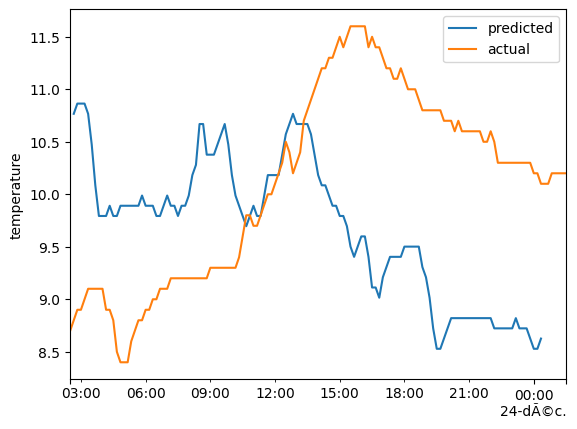

In [22]:
tmp.plot()
plt.ylabel("temperature")

In [23]:
tmp['actual'].fillna(method='bfill', inplace=True)

C:\Users\Zbook Create G7\AppData\Local\Temp\ipykernel_43628\3359853178.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp['actual'].fillna(method='bfill', inplace=True)


In [24]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [25]:
mae =  mean_absolute_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mape =  mean_absolute_percentage_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mae, mape

(1.2647911615540945, 0.13395331956604417)

In [26]:
mae =  mean_absolute_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mape =  mean_absolute_percentage_error(tmp.dropna()['predicted'], tmp.dropna()['actual'])
mae, mape

(1.2647911615540945, 0.13395331956604417)